In [1]:
%%bash
apt-get update -qq
apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
wget -q "https://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz" > /dev/null
tar -xvf spark-3.1.1-bin-hadoop2.7.tgz > /dev/null

pip install pyspark findspark --quiet
pip install sparknlp --quiet

In [4]:
# setup spark session
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# # Find Spark so that we can access session within our notebook
import findspark
findspark.init()

# Start SparkSession on all available cores
from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder \
    .master("local[*]")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.3.2")\
    .getOrCreate()

In [5]:
data = spark.read.csv('train1.csv',
                      header='true',
                      inferSchema='true',
                      multiLine=True)

In [7]:
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())
data.printSchema()

Total Columns: 5
Total Rows: 20800
root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



### Text Preprocessing

In [8]:
from pyspark.ml.feature import Word2Vec, Word2VecModel
from pyspark.ml.feature import StopWordsRemover, IDF, CountVectorizer
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import regexp_replace, array, col, udf, split
from pyspark.ml import Pipeline
from sparknlp.annotator import Lemmatizer, LemmatizerModel, Tokenizer, StopWordsCleaner, Normalizer
from sparknlp.base import DocumentAssembler, Finisher
from pyspark.ml.clustering import LDA
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [9]:
def doc_assembler(inputCol):
    '''Spark NLP document assembler'''
    
    return DocumentAssembler().setInputCol(inputCol)


def tokenizer(inputCol, outputCol):
    '''Tokenize text for input to the lemmatizer'''
    
    tokenizer = (Tokenizer()
        .setInputCols([inputCol])
        .setOutputCol(outputCol))
    return tokenizer


def stopwords(inputCol, outputCol):
    '''Remove stopwords'''

    stopwords = StopWordsCleaner.pretrained("stopwords_en", "en") \
        .setInputCols([inputCol]) \
        .setOutputCol(outputCol)
    return stopwords


def normalizer(inputCol, outputCol):
    '''Remove unnecessary characters and make tokens lowercase'''
    
    normalizer = (Normalizer() 
        .setInputCols([inputCol])
        .setOutputCol(outputCol)
        .setLowercase(True))
    return normalizer
          
    
def lemmatizer(inputCol, outputCol):
    '''
    Retrieve root words out of the input tokens
    using default pretrained lemmatizer
    '''
    
    lemmatizer = (LemmatizerModel.pretrained(name="lemma_antbnc", lang="en")
        .setInputCols([inputCol])
        .setOutputCol(outputCol))
    return lemmatizer


def finisher(finishedCol):
    '''Finisher transform for Spark NLP pipeline'''
    
    finisher = (Finisher()
        .setInputCols([finishedCol])
        .setIncludeMetadata(False))
    return finisher


def run_sparknlp_pipeline(df):
    """Create a SparkNLP pipeline that transforms the input DataFrame to procude a final output
       column storing each document as a sequence of lemmas (root words).
    """
    nlpPipeline = Pipeline(stages=[
        doc_assembler("text"),
        tokenizer("document", "token"),
        stopwords('token', 'token_s'),
        normalizer('token_s', 'cleaned_tokens'),
        lemmatizer("cleaned_tokens", "lemma"),
        finisher("lemma")
    ])
    df1 = nlpPipeline.fit(df).transform(df).withColumnRenamed('finished_lemma', 'allTokens')

    return df1

In [21]:
sampled_data = data.sample(fraction=0.5)

nlpPipelineDF = run_sparknlp_pipeline(sampled_data)

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [11]:
nlpPipelineDF.show()

+---+--------------------+--------------------+--------------------+-----+--------------------+
| id|               title|              author|                text|label|           allTokens|
+---+--------------------+--------------------+--------------------+-----+--------------------+
|  7|Benoît Hamon Wins...|     Alissa J. Rubin|PARIS  —   France...|    0|[paris, france, c...|
| 10|Obama’s Organizin...|         Aaron Klein|Organizing for Ac...|    0|[organize, action...|
| 12|Russian Researche...|       Amando Flavio|The mystery surro...|    1|[mystery, surroun...|
| 13|US Officials See ...|          Jason Ditz|Clinton Campaign ...|    1|[clinton, campaig...|
| 14|Re: Yes There Are...|        AnotherAnnie|Yes There Are Pai...|    1|[pay, government,...|
| 15|In Major League S...|       Jack Williams|Guillermo Barros ...|    0|[guillermo, barro...|
| 22|Rob Reiner: Trump...|             Pam Key|Sunday on MSNBC’s...|    0|[sunday, msnbcs, ...|
| 23|Massachusetts Cop...|              

In [12]:
print('Total Rows: %d' % nlpPipelineDF.count())
nlpPipelineDF.persist()

Total Rows: 6095


DataFrame[id: int, title: string, author: string, text: string, label: int, allTokens: array<string>]

### LDA: Count Vectorizer & Prepare for Topic Modeling

* Note: LDA code adopted from [this](https://github.com/lsc4ss-s21/large-scale-personal-finance/blob/main/4_Pyspark_topic_modeling.ipynb) sample project 

In [13]:
def count_vec(inputCol, outputCol, params):
    cv = CountVectorizer(
        inputCol=inputCol,
        outputCol=outputCol,
        vocabSize=params['vocabsize'],
        minDF=params['minDF'],
        maxDF=params['maxDF'],
        minTF=1.0
    )
    return cv

def idf(inputCol, outputCol):
    return IDF(inputCol="features", outputCol="idf")

def lda_model(params):
    lda = LDA(
        k=params['num_topics'],
        maxIter=params['iterations'],
        optimizer="online",
        seed=1,
        learningOffset = 100.0, 
        learningDecay = 0.75,
    )
    return lda


def lda_pipeline(df, params):
    '''
    Create a Spark ML pipeline and transform the input NLP-transformed DataFrame 
    to produce an LDA topic model.
    '''

    mlPipeline = Pipeline(
        stages=[
            count_vec("allTokens", "features", params),
            idf("features", "idf"),
            lda_model(params)
        ]
    )
    mlModel = mlPipeline.fit(df)
    ldaModel = mlModel.stages[2]
    
    return mlModel, ldaModel


In [42]:
lda_params = dict(num_topics = 10,
    iterations = 10,
    vocabsize = 7000,
    minDF = 0.02,
    maxDF = 0.8
 )
lda_params

{'num_topics': 10,
 'iterations': 10,
 'vocabsize': 7000,
 'minDF': 0.02,
 'maxDF': 0.8}

In [43]:
# separate fake and real news data
fake = nlpPipelineDF.filter(col("label") == 1)
real = nlpPipelineDF.filter(col("label") != 1)

f_mlModel, f_ldaModel = lda_pipeline(fake, lda_params)
r_mlModel, r_ldaModel = lda_pipeline(real, lda_params)

### Get Topics

In [23]:
def get_topics(mlModel, ldaModel, num_words=15):
    '''
    Get words and weights from the LDA model.
    '''
    # Store vocab from CountVectorizer
    vocab = mlModel.stages[0].vocabulary
    
    # Store LDA model part of pipeline
    ldaModel = mlModel.stages[2]

    # Take top n words in each topic
    topics = ldaModel.describeTopics(num_words)
    topics_rdd = topics.rdd

    topic_words = topics_rdd \
        .map(lambda row: row['termIndices']) \
        .map(lambda idx_list: [vocab[idx] for idx in idx_list]) \
        .collect()

    topic_weights = topics_rdd \
        .map(lambda row: row['termWeights']) \
        .collect()

    # Store topic words and weights as a list of dicts
    topics = [dict(zip(words, weights))
              for words, weights in zip(topic_words, topic_weights)]
    return topics

In [44]:
# get topics for real and fake news
fake_news_topics = get_topics(f_mlModel, f_ldaModel, 10)
real_news_topics = get_topics(r_mlModel, r_ldaModel, 10)

In [48]:
# Plot topic wordclouds
def wordclouds(topics, fname, colormap="viridis"):
    cloud = WordCloud(
        background_color='white',
        width=600,
        height=400,
        colormap=colormap,
        prefer_horizontal=1.0,
    )

    num_topics = len(topics)
    fig = plt.figure(figsize=(16, 10))

    for idx, word_weights in tqdm(enumerate(topics), total=num_topics):
        ax = fig.add_subplot(int((num_topics / 5)) + 1, 5, int(idx + 1))
        wordcloud = cloud.generate_from_frequencies(word_weights)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title('Topic {}'.format(idx + 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

    plt.tick_params(labelsize=14)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.margins(x=0.1, y=0.1)
    fig.savefig(fname, bbox_inches='tight')
    plt.show()


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


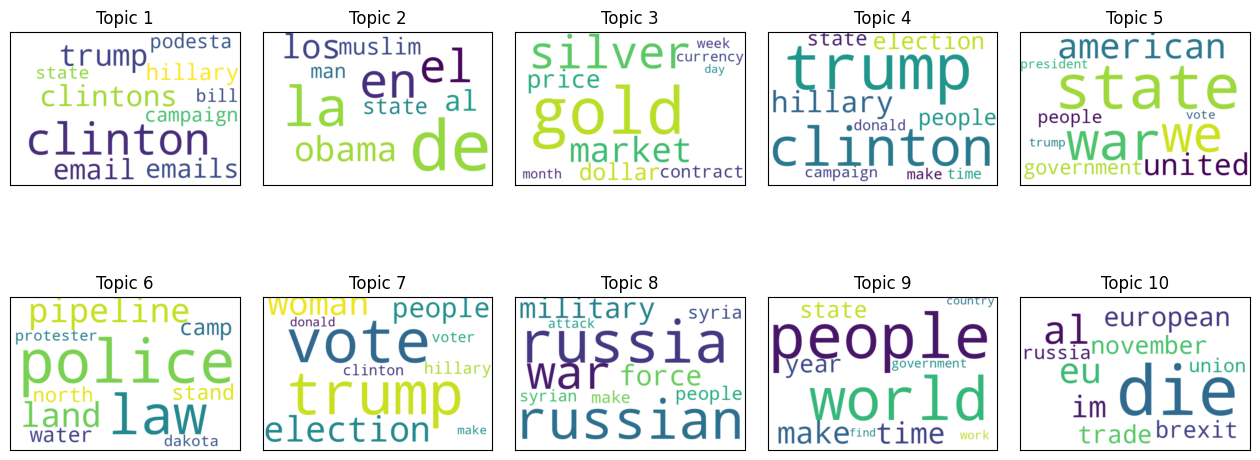

In [49]:
# plot fake news topics
plt.close()
wordclouds(fake_news_topics, 'fake_topics.png')

100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


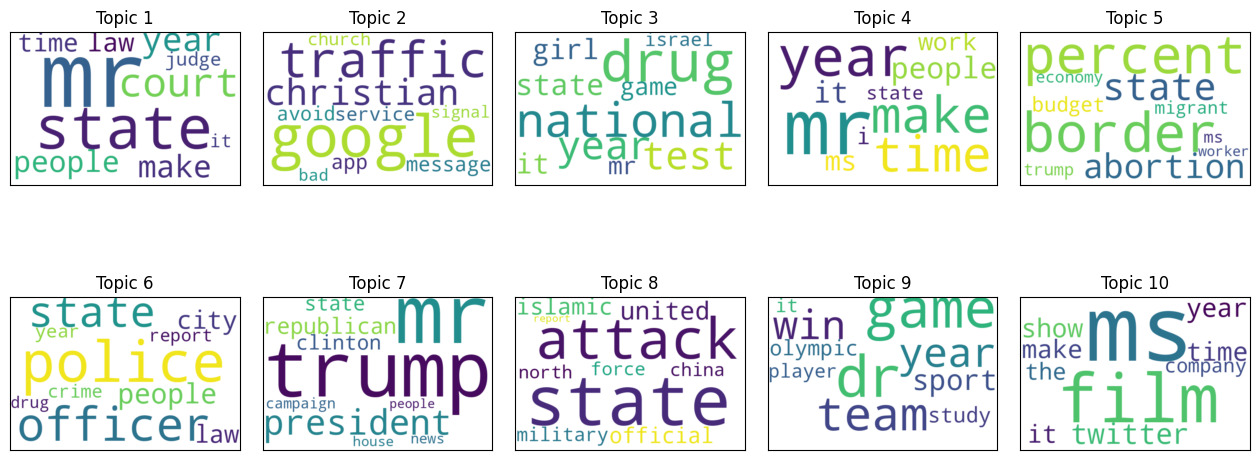

In [50]:
# plot real news topics
plt.close()
wordclouds(real_news_topics, 'real_topics.png')